In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import glob
import os
import subprocess
import tempfile

import IPython
import ggplot as gg
import pandas as pd

import date_group as dg
import preprocessing as prp
import util

In [3]:
incorrect_descriptives = util.validate_descriptives(
    glob.glob("data_output/by_country_by_hour/user_country_710_*"), 
              "data_output/descriptives/by_country_by_hour")
incorrect_descriptives

[]

In [4]:
# pakeisti kiekvinam paleidimui
country_id = "710"
description_part = "first_4_weeks"
n_testing_periods = 10

In [5]:
filenames = glob.glob("data_output/by_country_by_hour/user_country_{}_*".format(country_id))

dt_fn_pairs = dg.make_datetime_filename_pairs(filenames)

splits = dg.make_training_testing_datasets(
        datetime_filename_pairs=dt_fn_pairs,
        n_training_periods=4,
        training_period_type='week',
        n_testing_periods=1,
        testing_period_type='day',
        n_window_periods=1,
        window_period_type='week',
        datetime_from=None,
        datetime_to=None,
        min_testing_datasets=n_testing_periods,
        has_named_tuples=False)

In [6]:
len(splits)

4

In [7]:
# geriau nekeisti zemiau

In [8]:
dir_output = "data_output/country_{}_{}".format(country_id, description_part)
dir_output

'data_output/country_710_first_4_weeks'

In [9]:
training_filenames = splits[0][0][1]

training_descriptives_dirs = util.mk_paths_descr_from_dataset(
    training_filenames, "data_output/descriptives/by_country_by_hour")

target_counts = prp.merge_descriptives(
    training_descriptives_dirs, ["impression_was_clicked"]
)["impression_was_clicked"]

n_neg, n_pos = target_counts["0"], target_counts["1"]

prob_neg_subsampling = prp.calc_prob_neg_sampling(n_neg, n_pos, 0.1)

## Modeliavimas

In [15]:
VW_HOME = os.path.join(os.path.expanduser("~"), "vowpal_wabbit")
PATH_VW_UTL = os.path.join(VW_HOME, 'utl')
PATH_VW_HS = os.path.join(PATH_VW_UTL, "vw-hypersearch")

In [16]:
_, tmp_path_training_files = tempfile.mkstemp()

with open(tmp_path_training_files, "w") as f:
    f.write(" ".join(training_filenames))

path_train = "tmp_train.vw"
path_validation = "tmp_validation.vw" 

os.makedirs(dir_output, exist_ok=True)

hs_split_pipe_parts = [
    "cat {}".format(tmp_path_training_files),
    "./cat_csv",
    "./downsample --min_pos_ratio=0.1 {} {}".format(n_pos, n_neg),
    "./csv_2_vw",
    "./split --seed=2000 --probability=0.7 {} {}".format(path_train, path_validation)
]

hs_split_cmd = " | ".join(hs_split_pipe_parts)
    
hs_training_vw_cmd = " ".join([
        "vw",
        "--loss_function logistic",
        "-f {}/serialized.model".format(dir_output),
        "--cache",
        "--passes 20",
        "--l1 %",
        "--readable_model {}/auto_model.txt".format(dir_output),
        "-d {}".format(path_train)
    ])

hs_cmd = " ".join([
        PATH_VW_HS,
        "-t {}".format(path_validation),
        "-L",
        "0.000000001",
        "0.001",
        hs_training_vw_cmd,
        "> {}/best_L1_reg.txt 2>&1; rm *.cache;".format(dir_output)
    ])

#### Modeliavimo vykdymas

In [17]:
subprocess.call(hs_split_cmd, shell=True, executable="/bin/bash")

0

In [18]:
subprocess.call(hs_cmd, shell=True, executable="/bin/bash")

0

In [19]:
os.remove(tmp_path_training_files)

## Modelio įvertinimas

In [20]:
testing_datasets = splits[0][1][:n_testing_periods]

#### Prognozavimas

In [21]:
for i, (interval, fnames) in enumerate(testing_datasets):
    testing_vw_cmd = " ".join([
            "vw",
            "--loss_function logistic",
            "-i data_output/baseline.model",
            "--testonly",
            "-p {}/predictions_{}.txt".format(dir_output, i)
        ])
    
    testing_pipe_parts = [
            "echo {}".format(" ".join(fnames)),
            "./cat_csv",
            "./csv_2_vw",
            testing_vw_cmd
        ]
    
    testing_pipe = " | ".join(testing_pipe_parts)
    subprocess.call(testing_pipe, shell=True)

#### Metrikų skaičiavimas

In [22]:
for i, (interval, fnames) in enumerate(testing_datasets):
    evaluation_pipe_parts = [
            "echo {}".format(" ".join(fnames)),
            "./cat_csv",
            "./extract_column impression_was_clicked",
            "./mk_eval_input {}/predictions_{}.txt".format(dir_output, i),
            "./eval_model > {}/metrics_{}.txt".format(dir_output, i)
        ]
    
    evaluation_pipe = " | ".join(evaluation_pipe_parts)
    subprocess.call(evaluation_pipe, shell=True)

#### Metrikų apjungimas

In [23]:
metrics_dfs = [
    ("{}/metrics_{}.txt".format(dir_output, i), 
     pd.read_csv('{}/metrics_{}.txt'.format(dir_output, i), sep="\t", 
                 index_col=0, header=None).T,)
    for i in range(len(testing_datasets))
]

for i, (p, df) in enumerate(metrics_dfs):
    df["i_test_period"] = i + 1

metrics_df = pd.concat(df for _, df in metrics_dfs).reset_index(drop=True)
metrics_df.to_csv(os.path.join(dir_output, "metrics.csv"), index=None)

In [24]:
metrics_df

0       ACC       PRE       REC       PRF      LFT       AUC  i_test_period
0  0.872960  0.636364  0.003453  0.006869  5.00175  0.688390              1
1  0.837946  1.000000  0.004474  0.008909  6.14318  0.671128              2
2  0.871818  0.800000  0.004670  0.009286  6.21926  0.687390              3
3  0.857943  0.000000  0.000000  0.000000  0.00000  0.709223              4
4  0.864153  0.166667  0.000824  0.001639  1.23092  0.700067              5
5  0.857859  0.666667  0.001720  0.003431  4.68616  0.732600              6
6  0.871595  0.333333  0.002311  0.004591  2.60195  0.707752              7
7  0.864801  0.411765  0.003406  0.006757  3.05006  0.695040              8
8  0.852936  0.428571  0.001752  0.003490  2.91589  0.689916              9
9  0.840181  0.250000  0.000833  0.001661  1.56688  0.682908             10

In [25]:
metrics_long_df = pd.melt(
    metrics_df, 
    id_vars=["i_test_period"], 
    value_vars=["PRE", "REC", "PRF", "AUC"], 
    var_name="variable")

In [26]:
metrics_long_df

i_test_period variable     value
0               1      PRE  0.636364
1               2      PRE  1.000000
2               3      PRE  0.800000
3               4      PRE  0.000000
4               5      PRE  0.166667
5               6      PRE  0.666667
6               7      PRE  0.333333
7               8      PRE  0.411765
8               9      PRE  0.428571
9              10      PRE  0.250000
10              1      REC  0.003453
11              2      REC  0.004474
12              3      REC  0.004670
13              4      REC  0.000000
14              5      REC  0.000824
15              6      REC  0.001720
16              7      REC  0.002311
17              8      REC  0.003406
18              9      REC  0.001752
19             10      REC  0.000833
20              1      PRF  0.006869
21              2      PRF  0.008909
22              3      PRF  0.009286
23              4      PRF  0.000000
24              5      PRF  0.001639
25              6      PRF  0.003431
26              7      PRF  0.004591
27              8      PRF  0.006757
28              9      PRF  0.003490
29             10      PRF  0.001661
30              1      AUC  0.688390
31              2      AUC  0.671128
32              3      AUC  0.687390
33              4      AUC  0.709223
34              5      AUC  0.700067
35              6      AUC  0.732600
36              7      AUC  0.707752
37              8      AUC  0.695040
38              9      AUC  0.689916
39             10      AUC  0.682908

/home/vagrant/.miniconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


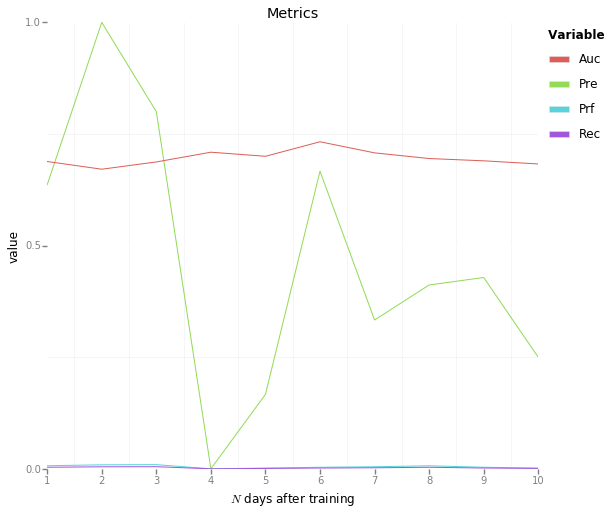

<ggplot: (-895101788)>

In [27]:
(
    gg.ggplot(metrics_long_df, gg.aes(x="i_test_period", y="value", color="variable")) + 
    gg.geom_line() + 
    gg.xlab("$N$ days after training") + 
    gg.ggtitle("Metrics") +
    # uzkomentuoti jei nereikia tuscios vietos
    gg.ylim(0, 1) +
    gg.theme_bw()
)